## DSCI 100 Project Proposal: Classifying star category using temperature, luminosity, radius, and absolute magnitude as predictors.

### Introduction

In the celestial realm, stars are crucial celestial entities, each characterized by unique spectral and physical attributes. Contrary to ancient methods of classification that utilized constellations and positions in the sky, scientific reasoning in modern astrophysics seeks a unified understanding. Being such complex bodies, classifying the various star types can become ambiguous, thus demanding rigorous analysis of the various multifaceted characteristics through quantifiable values.

**Question:** Can we successively predict the star type based on data including temperature, luminosity, radius and absolute magnitude? 

**Dataset Description**

For the purpose of the project we will be using the Star Classification dataset provided by the YBI Foundation on [Kaggle](https://www.kaggle.com/code/ybifoundation/stars-classification). Initially, there are 8 columns and 240 rows. The data contains the following variables: star absolute temperature(in K), relative luminosity (L/Lo), relative radius (R/Ro), absolute magnitude (Mv), colour, spectral class, and star type. Not all of these variables serve a purpose as many are classifications not predictors, more information on our variable selection in the **methods** section. 


### Preliminary exploratory data analysis

**Setting Up Libraries and Parameters**

In [1]:
# Run this first.
library(tidyverse)
library(tidymodels)
library(repr)
install.packages("gridExtra")
library(gridExtra)
install.packages("kknn")
library(kknn)

# Importing data
dataset_url <- "https://raw.githubusercontent.com/YBIFoundation/Dataset/main/Stars.csv"

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

**Loading and tidying data**

In [2]:
set.seed(1234)

# loading and tidying
star_raw_data <- read_csv(dataset_url) 

star_data <- star_raw_data |>
    rename(temperature = "Temperature (K)",
           luminosity = "Luminosity (L/Lo)",
           radius = "Radius (R/Ro)",
           absolute_magnitude = "Absolute magnitude (Mv)",
           star_type = "Star type",
           star_category = "Star category",
           star_colour = "Star color",
           spectral_class = "Spectral Class") |>
    select(temperature:absolute_magnitude,star_category) |> 
    drop_na()
    

# splitting and creating training and testing data
star_data_split <- star_data |>
    initial_split(props=0.75, strata=star_category)

star_training_data <- training(star_data_split)
star_testing_data <- testing(star_data_split)

# head and summary of our data
summary_by_star_category <- star_data |>
    group_by(star_category) |>
    summarize(count = n(), across(everything(), median))
summary_by_star_category

# From training data finding percentages
star_proportions <- star_training_data |>
    group_by(star_category) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(star_training_data))

star_proportions    

Rows: 240 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Star category, Star color, Spectral Class
dbl (5): Temperature (K), Luminosity (L/Lo), Radius (R/Ro), Absolute magnitu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


star_category count temperature luminosity  radius    absolute_magnitude
1 Brown Dwarf   40     2935.0     5.20000e-04    0.1060 17.145            
2 Hypergiant    40     3766.0     2.66500e+05 1352.5000 -9.915            
3 Main Sequence 40    12560.5     7.38500e+02    5.7125 -1.180            
4 Red Dwarf     40     3314.0     3.15000e-03    0.3380 12.605            
5 Supergiant    40    12821.0     2.42145e+05   43.5000 -6.235            
6 White Dwarf   40    13380.0     7.60000e-04    0.0102 12.340

star_category n  percent 
1 Brown Dwarf   30 16.66667
2 Hypergiant    30 16.66667
3 Main Sequence 30 16.66667
4 Red Dwarf     30 16.66667
5 Supergiant    30 16.66667
6 White Dwarf   30 16.66667

**Preliminary Data Visualization**

In [12]:
#Scatter Plot for the predictors in a pair

options(repr.plot.height = 10, repr.plot.width = 10)
tempvslumn <- star_data |>
         ggplot(aes (x = temperature,
                     y = luminosity,
                     colour = star_category)) +
         geom_point() +
         labs(x = "Temperature(K) (not standardized)",
              y = "Luminosity (L/Lo) (not standardized)" ,
              colour = 'Star Type') +
         geom_point(size = 2.5)

tempvsradi <- star_data |>
         ggplot(aes (x = temperature,
                     y = radius,
                     colour = star_category)) +
         geom_point() +
         labs(x = "Temperature(K) (not standardized)",
              y = "Radius (R/Ro) (not standardized)" ,
              colour = 'Star Type') +
         geom_point(size = 2.5)

tempvsmagn <- star_data |>
         ggplot(aes (x = temperature,
                     y = absolute_magnitude,
                     colour = star_category)) +
         geom_point() +
         labs(x = "Temperature(K) (not standardized)",
              y = "Absolute Magnitude (Mv) (not standardized)" ,
              colour = 'Star Type') +
         geom_point(size = 2.5)

lumnvsradi <- star_data |>
         ggplot(aes (x = luminosity,
                     y = radius,
                     colour = star_category)) +
         geom_point() +
         labs(x = "Luminosity (L/Lo) (not standardized)",
              y = "Radius (R/Ro) (not standardized)" ,
              colour = 'Star Type') +
         geom_point(size = 2.5)


lumnvsmagn <- star_data |>
         ggplot(aes (x = luminosity,
                     y = absolute_magnitude,
                     colour = star_category)) +
         geom_point() +
         labs(x = "Luminosity (L/Lo) (not standardized)",
              y = "Absolute Magnitude (Mv) (not standardized)" ,
              colour = 'Star Type') +
         geom_point(size = 2.5)


radivsmagn <- star_data |>
         ggplot(aes (x = radius,
                     y = absolute_magnitude,
                     colour = star_category)) +
         geom_point() +
         labs(x = "Radius (R/Ro) (not standardized)",
              y = "Absolute Magnitude (Mv) (not standardized)" ,
              colour = 'Star Type') +
         geom_point(size = 2.5)


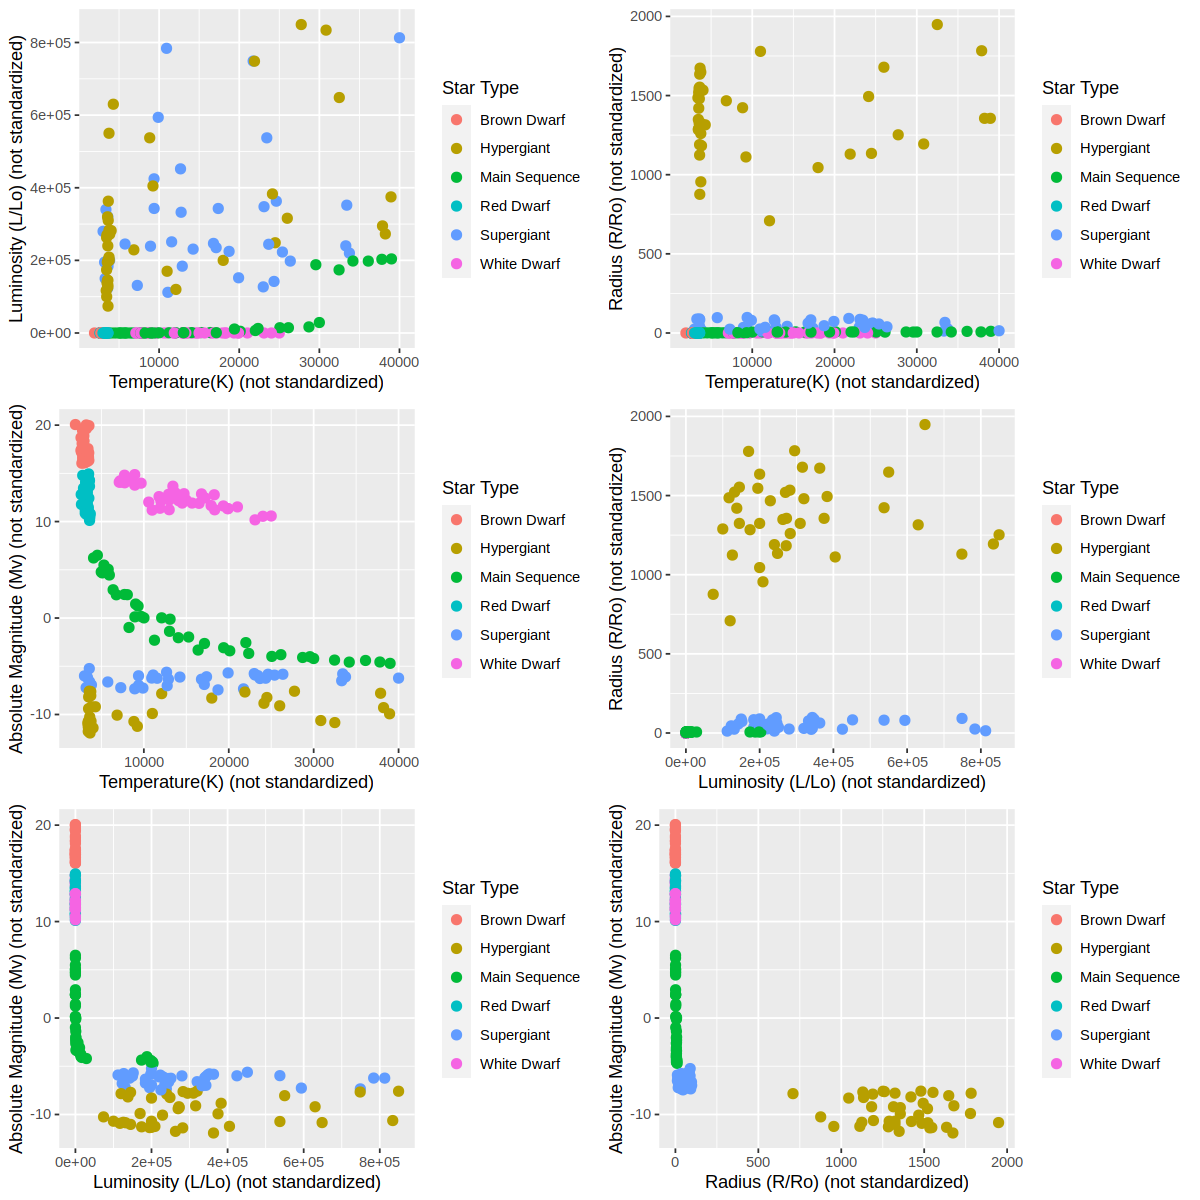

In [13]:
#Organizing the scatter plots in a grid
options(repr.plot.height = 10, repr.plot.width = 10)
grid.arrange(tempvslumn,tempvsradi, tempvsmagn, lumnvsradi, lumnvsmagn, radivsmagn, ncol = 2)

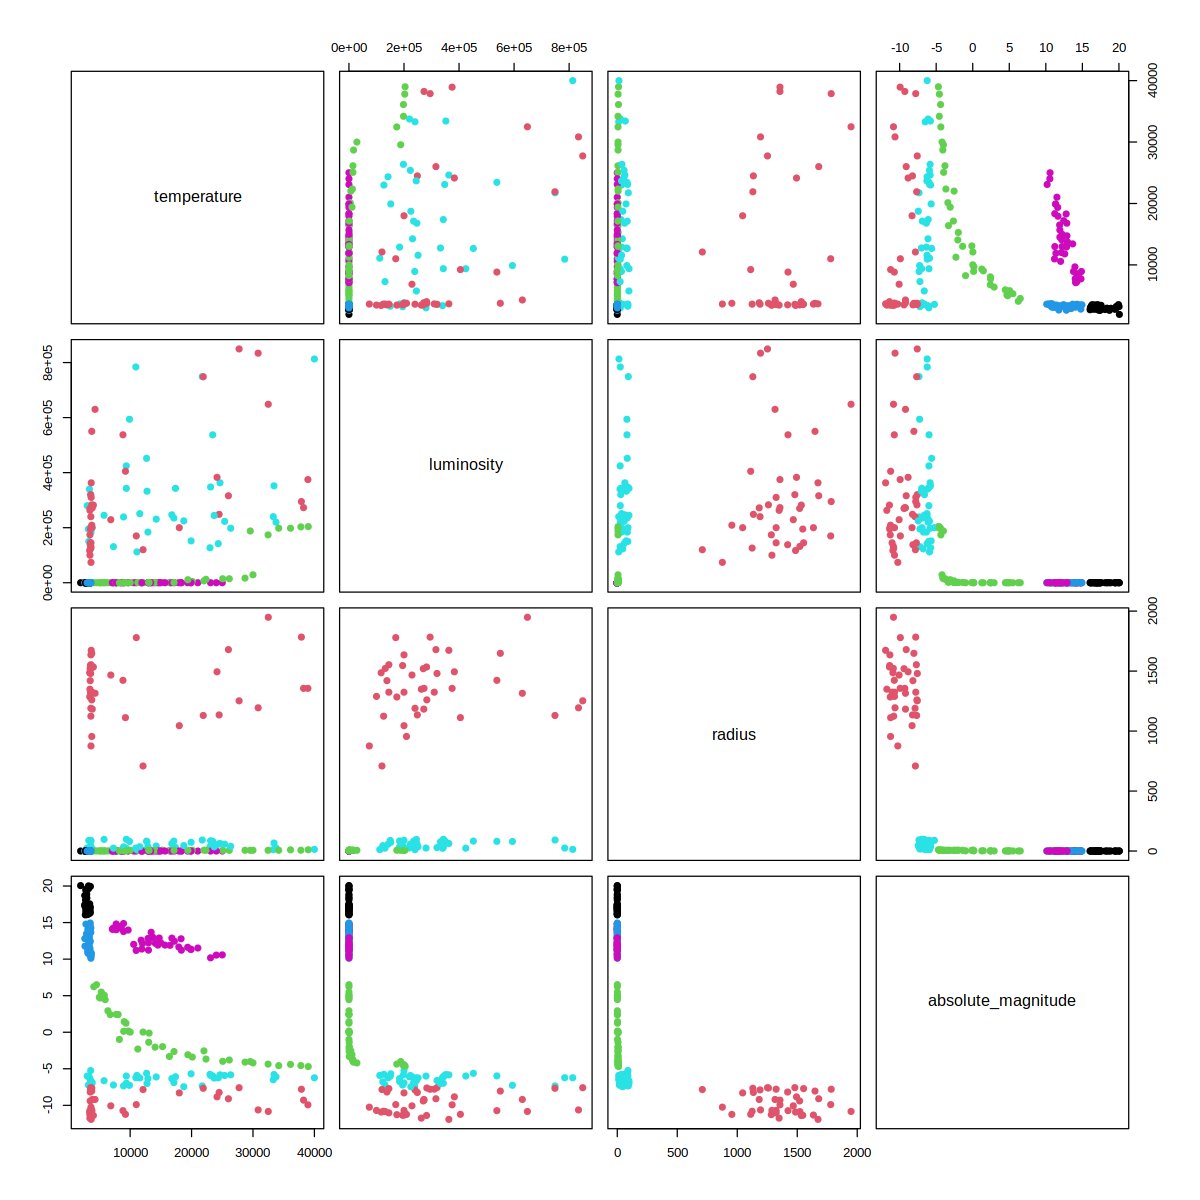

In [9]:
options(repr.plot.height = 10, repr.plot.width = 10)
#Using pairs() to plot for each possible pair
star_predictors <- star_data |>
         select(temperature,luminosity,radius, absolute_magnitude)

#encoding the cartegorical data to numeric
color_mapping <- as.numeric(factor(star_data$star_category))


#producing pairs of each possible predictors
pairs(star_predictors,pch = 19, col = color_mapping)


### Methods

From the summary tables, it is evident that for all six star categories, there are distinguishable differences within all used predictors, meaning that successful classification in predicting observations will be possible. 

Using the processed Star Classification dataset, where libraries such as tidyverse, repr, and tidymodels have been used, we can utilize the data to determine the star category. The following variables serve as potential predictors:
*  **Temperature**
*  **Luminosity**
*  **Radius**
*  **Absolute Magnitude** 

Star type is chosen as our class reasoning due to its vague characteristics that can be used as predictors to classify the types of stars. Analyzing star colour or spectral class for classification relies on observation as opposed to predictive reasoning.


KNN is chosen as our predictive model due to the star type's categorical nature and its ability to capture nonlinear boundaries present in the star dataset. Thus providing a more interpretable and reliable approach. The justification for not choosing star spectral class and star colour was that their categorical nature could disrupt the KNN classifications that rely on numeric computation.


**Finding Optimal K value**

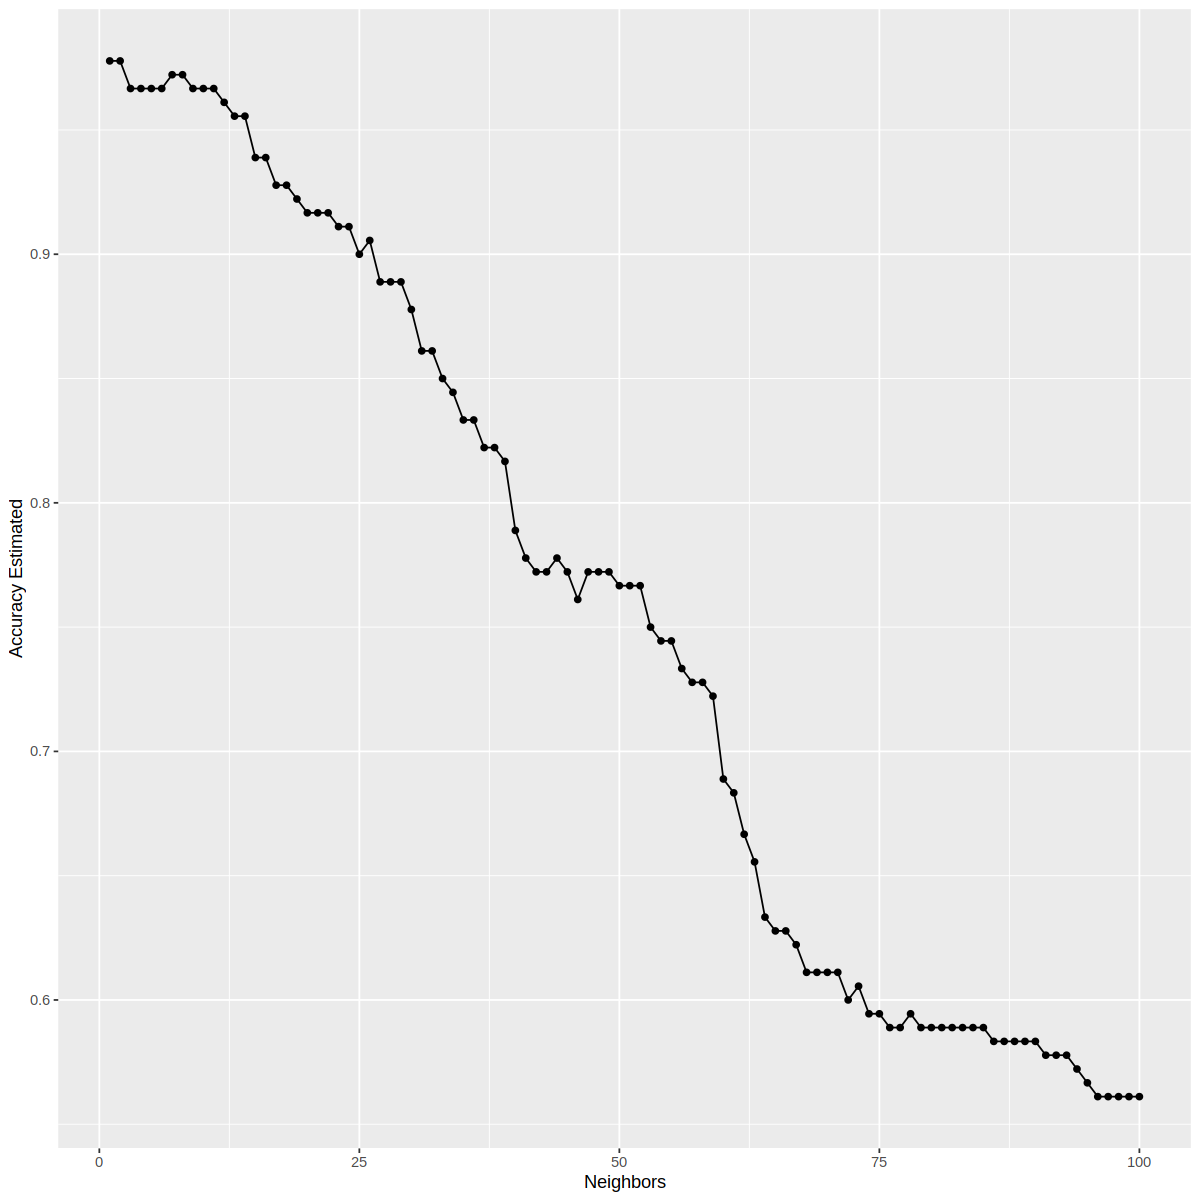

In [10]:
options(repr.plot.height = 10, repr.plot.width = 10)
# Creating recipe with standardized data
star_recipe <- recipe(star_category~temperature+luminosity+radius+absolute_magnitude, data = star_training_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# Setting our model for training data
tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Creating the fit for knn_spec
knn_workflow <- workflow() |>
    add_recipe(star_recipe) |>
    add_model(tune_spec)

k_vfold <- vfold_cv(star_training_data, v = 5, strata = star_category)

k_vals <- tibble(neighbors = seq(1,100))

knn_results <- knn_workflow |>
    tune_grid(resamples = k_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- accuracies |>
    ggplot(aes(x=neighbors,y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Neighbors", y="Accuracy Estimated")
cross_val_plot


**Visualization**

As seen in our **preliminary data visualization**, we have utilized pair graphs since we have four predictors, therefore enabling us to see trends within the matrix of scatterplots. Therefore, pair graphs will be our primary form of visualization within this project.


### Expected Outcomes and Significance

We predict that after using KNN classification on our modified dataset, we can predict star types based on the chosen predictors successively. This enables a deeper understanding of the distinguishing characteristics of various star types. Utilizing star classification to predict the star type can be highly significant for astronomers to identify distinct patterns and gain a higher understanding of the universe. 

**Future Questions**
1. Can we use this algorithm to successfully predict the star type of the sun?
2. To what extent is KNN classification a more fitting way of analyzing the data rather than other algorithms?


### References

Britannica, The Editors of Encyclopaedia. "stellar classification". Encyclopedia Britannica, 22 Aug. 2023, https://www.britannica.com/science/stellar-classification. Accessed 29 November 2023.

“Stars - NASA Science.” NASA, 2023, https://science.nasa.gov/astrophysics/focus-areas/how-do-stars-form-and-evolve/. Accessed 24 Oct. 2023.

YBI Foundation. “Stars Classification.” Kaggle, 9 Mar. 2023, https://www.kaggle.com/code/ybifoundation/stars-classification. Accessed 25 Oct. 2023. 